In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import os.path as osp

# Set the number of (emulated) host devices
num_devices = 4
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={num_devices}"

import numpy as np

import jax
import jax.numpy as jnp
from jax import lax
import gymnax
from gymnax.visualize import Visualizer

jax.device_count(), jax.devices()

(4, [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)])

In [3]:
from functools import partial

from utils.models import get_model_ready
from utils.helpers import load_config, save_pkl_object


from src.control.dynamics import cartpole_step,CartPoleEnvState,kinematics
from src.control.MPPI import MPPI_wrapper,MPPI_ptb,weighting,MPPI_scores_wrapper,MPPI_control,weighting
from src.objective_fns.cost_to_go_fns import cart_pole_cost
from src.objective_fns.objectives import MPC_decorator

In [4]:
dynamic_rollout = jax.jit(partial(kinematics,step_fn=cartpole_step))

mppi = MPPI_wrapper(dynamic_rollout)

mpc_obj = MPC_decorator(cart_pole_cost,dynamic_rollout,0.99)

mppi_scores = MPPI_scores_wrapper(mpc_obj)

weight_fn = weighting()

In [5]:
class Args(object):
  def __init__(self):
    pass

args = Args()

args.num_traj = 350
args.horizon = 50
args.MPPI_iterations=50

In [6]:
random_key = jax.random.PRNGKey(123)

In [7]:
state = jnp.array([1.5,0.04,0.02,-0.05])

U = jnp.array(np.random.randn(15,args.horizon,1)*0.2)
U_nominal = U.mean(axis=0)

cov = jnp.eye(args.horizon)*10

In [8]:
state_seq_mppi = [CartPoleEnvState(t=0,x=state[0],x_dot=state[1],theta=state[2],theta_dot=state[3])]
rewards = [cart_pole_cost(state)]
for i in range(200):
  U_nominal, (states,states_MPPI), cost_MPPI,key = MPPI_control(state,U_nominal,cov,random_key,
              dynamic_rollout,jnp.array([[-15,15]]),
              mppi,mppi_scores,weight_fn,
              args)
  
  state = states[0]
  rewards.append(cart_pole_cost(state))
  state_seq_mppi.append(CartPoleEnvState(t=i+1,x=state[0],x_dot=state[1],theta=state[2],theta_dot=state[3]))

# print(U_nominal.shape)
# print("U: ",U_nominal)
  print("State: ",state)

rewards = np.array(rewards)


State:  [ 1.5008      0.23482955  0.019      -0.33630626]
State:  [ 1.50549659  0.42967602  0.01227387 -0.62293757]
State:  [ 1.51409011e+00  6.24624466e-01 -1.84876578e-04 -9.11729773e-01]
State:  [ 1.5265826   0.81974892 -0.01841947 -1.2044708 ]
State:  [ 1.54297758  1.01510405 -0.04250889 -1.50286881]
State:  [ 1.56327966  1.21071542 -0.07256626 -1.80851465]
State:  [ 1.58749397  1.40656775 -0.10873656 -2.12283574]
State:  [ 1.61562532  1.32490818 -0.15119327 -2.0329754 ]
State:  [ 1.64212349  1.13163517 -0.19185278 -1.79065481]
State:  [ 1.66475619  0.93911333 -0.22766588 -1.5632298 ]
State:  [ 1.68353846  0.74732159 -0.25893047 -1.34932276]
State:  [ 1.69848489  0.55621128 -0.28591693 -1.14749123]
State:  [ 1.70960911  0.36571638 -0.30886675 -0.95626801]
State:  [ 1.71692344  0.17576078 -0.32799211 -0.77418792]
State:  [ 1.72043866 -0.01373691 -0.34347587 -0.59980426]
State:  [ 1.72016392 -0.20286012 -0.35547196 -0.43169754]
State:  [ 1.71610672 -0.39169248 -0.36410591 -0.26847869

In [9]:
U_nominal

Array([[-3.89864783e-03],
       [-1.36099080e+01],
       [-1.47663058e+01],
       [-1.28956457e+01],
       [ 1.50000000e+01],
       [ 1.50000000e+01],
       [ 1.44927280e+01],
       [ 1.50000000e+01],
       [ 1.45116805e+01],
       [-1.50000000e+01],
       [-1.42506846e+01],
       [-1.50000000e+01],
       [ 1.50000000e+01],
       [-1.50000000e+01],
       [ 1.50000000e+01],
       [ 1.50000000e+01],
       [ 1.50000000e+01],
       [-1.50000000e+01],
       [-1.50000000e+01],
       [ 1.50000000e+01],
       [-3.76945058e-02],
       [-8.90462473e+00],
       [ 1.30298234e+01],
       [ 1.50000000e+01],
       [-1.29486157e+01],
       [ 1.40082332e+01],
       [ 1.50000000e+01],
       [-1.50000000e+01],
       [ 1.50000000e+01],
       [-1.50000000e+01],
       [-1.10557818e+01],
       [-1.47393006e+01],
       [ 5.20687316e+00],
       [ 1.50000000e+01],
       [ 1.50000000e+01],
       [ 1.50000000e+01],
       [ 5.46244186e-01],
       [-7.30911305e+00],
       [-1.1

In [10]:
base =  osp.join("expert_agents","CartPole-v1","ppo")
configs = load_config(base + ".yaml")

In [11]:
env, env_params = gymnax.make(
        configs.train_config.env_name,
        **configs.train_config.env_kwargs,
    )
env_params.replace(**configs.train_config.env_params)

EnvParams(max_steps_in_episode=500, gravity=9.8, masscart=1.0, masspole=0.1, total_mass=1.1, length=0.5, polemass_length=0.05, force_mag=10.0, tau=0.02, theta_threshold_radians=0.20943951023931953, x_threshold=2.4)

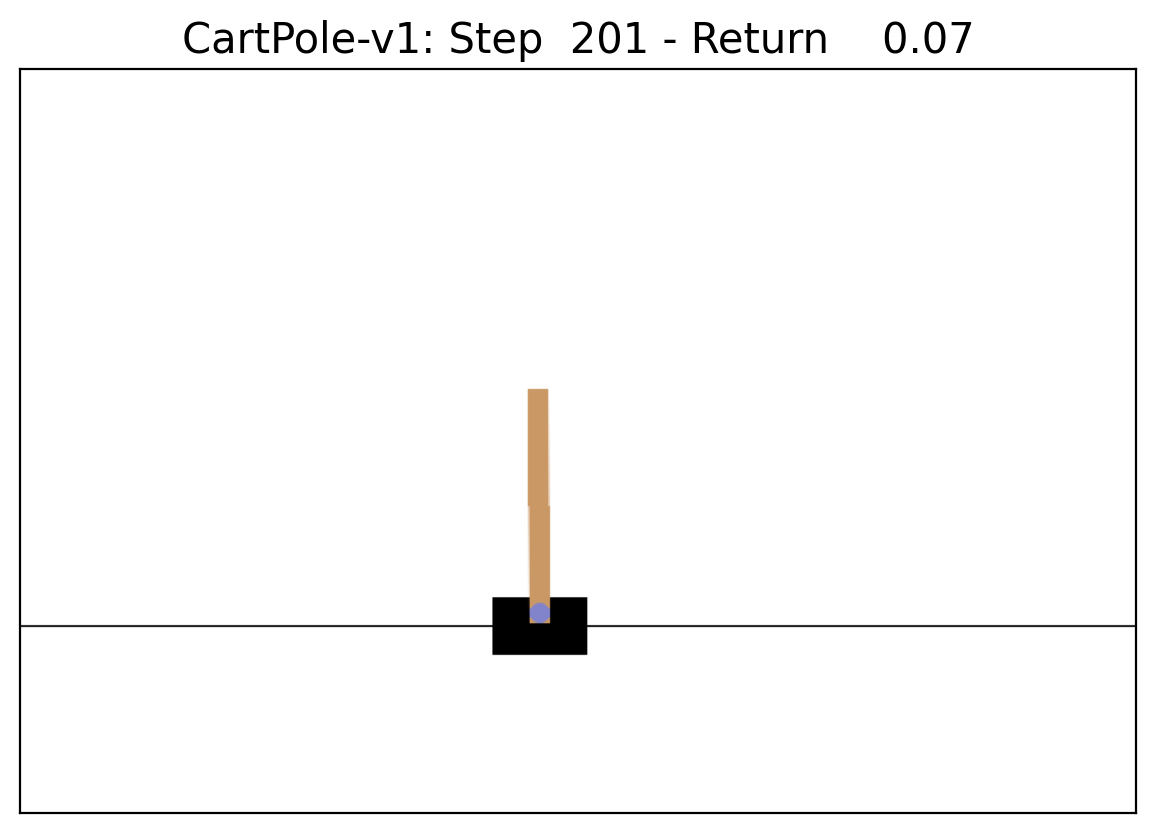

In [13]:
vis = Visualizer(env, env_params, state_seq_mppi, rewards)
vis.animate(osp.join("results","CartPole-v1-mppi.gif"))

## Random Action Demo

In [14]:
state = jnp.array([1.5,0.04,0.02,-0.05])

In [15]:
state_seq_random = [CartPoleEnvState(t=0,x=state[0],x_dot=state[1],theta=state[2],theta_dot=state[3])]
rewards = [cart_pole_cost(state)]
for i in range(200):
  action = jnp.array(np.random.randn(1,))*5

  
  state = cartpole_step(action,state)
  
  rewards.append(cart_pole_cost(state))
  state_seq_random.append(CartPoleEnvState(t=i+1,x=state[0],x_dot=state[1],theta=state[2],theta_dot=state[3]))

# print(U_nominal.shape)
# print("U: ",U_nominal)
  print("State: ",state, "Action: ",action)

rewards = np.array(rewards)

State:  [ 1.5008     -0.02525242  0.019       0.05373867] Action:  [-3.32959096]
State:  [ 1.50029495 -0.17816153  0.02007477  0.2886466 ] Action:  [-7.82283991]
State:  [ 1.49673172 -0.22825433  0.02584771  0.36967225] Action:  [-2.55266441]
State:  [ 1.49216663 -0.29460571  0.03324115  0.47676444] Action:  [-3.3818612]
State:  [ 1.48627452 -0.4175662   0.04277644  0.67087438] Action:  [-6.27819789]
State:  [ 1.4779232  -0.38095809  0.05619393  0.62858489] Action:  [1.90685653]
State:  [ 1.47030403 -0.41710714  0.06876562  0.69923519] Action:  [-1.8129601]
State:  [ 1.46196189 -0.39653146  0.08275033  0.68864578] Action:  [1.10357159]
State:  [ 1.45403126 -0.38584664  0.09652324  0.69697423] Action:  [0.6064552]
State:  [ 1.44631433 -0.55733862  0.11046273  0.98134862] Action:  [-8.72677314]
State:  [ 1.43516756 -0.54524314  0.1300897   0.99572602] Action:  [0.6956674]
State:  [ 1.42426269 -0.5549487   0.15000422  1.04829993] Action:  [-0.40991219]
State:  [ 1.41316372 -0.61729474  0.

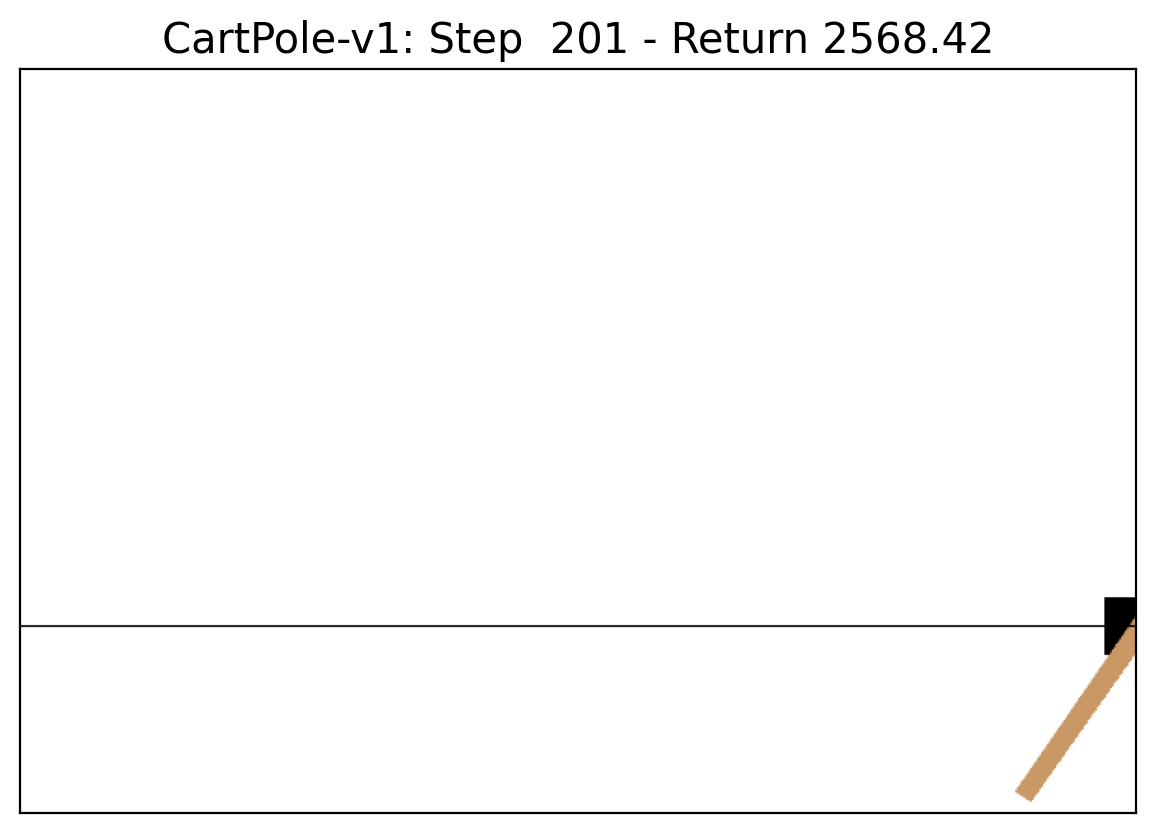

In [16]:
vis = Visualizer(env, env_params, state_seq_random,rewards)
vis.animate(osp.join("results","CartPole-v1-random.gif"))

## Expert Demo

In [17]:
from utils.models import load_neural_network

In [18]:
base =  osp.join("expert_agents","CartPole-v1","ppo")
configs = load_config(base + ".yaml")
model, model_params = load_neural_network(
    configs.train_config, base + ".pkl"
)

Loaded data from expert_agents\CartPole-v1\ppo.pkl.


In [37]:
from flax import struct
from gymnax.environments import EnvState

@struct.dataclass
class EnvState(EnvState):
    x: jnp.ndarray
    x_dot: jnp.ndarray
    theta: jnp.ndarray
    theta_dot: jnp.ndarray
    time: int

In [46]:
def rollout_episode(env, env_params, model, model_params, max_frames=200):
    state_seq = []
    rng = jax.random.PRNGKey(0)

    rng, rng_reset = jax.random.split(rng)
    # obs, env_state = env.reset(rng_reset, env_params)

    obs = jnp.array([0.8,0.04,0.02,-0.05])
    env_state = EnvState(
          x=obs[0],
          x_dot=obs[1],
          theta=obs[2],
          theta_dot=obs[3],
          time=0,
      )
  
    if model is not None:
        if model.model_name == "LSTM":
            hidden = model.initialize_carry()

    t_counter = 0
    reward_seq = []
    while True:
        state_seq.append(env_state)
        rng, rng_act, rng_step = jax.random.split(rng, 3)

        v, pi = model.apply(model_params, obs, rng_act)

        action = pi.sample(seed=rng_act)

        next_obs, next_env_state, reward, done, info = env.step(
            rng_step, env_state, action, env_params
        )
      
        reward_seq.append(reward)
        print(t_counter, reward, action, done)
        print(10 * "=")
        t_counter += 1
        if done or t_counter == max_frames:
            break
        else:
            env_state = next_env_state
            obs = next_obs
    print(f"{env.name} - Steps: {t_counter}, Return: {np.sum(reward_seq)}")
    return state_seq, np.cumsum(reward_seq)

In [47]:
env, env_params = gymnax.make(
        configs.train_config.env_name,
        **configs.train_config.env_kwargs,
    )
env_params.replace(**configs.train_config.env_params)
state_seq, cum_rewards = rollout_episode(
    env, env_params, model, model_params
)

0 1.0 1 False
1 1.0 1 False
2 1.0 0 False
3 1.0 1 False
4 1.0 1 False
5 1.0 1 False
6 1.0 1 False
7 1.0 0 False
8 1.0 0 False
9 1.0 0 False
10 1.0 0 False
11 1.0 1 False
12 1.0 0 False
13 1.0 0 False
14 1.0 0 False
15 1.0 0 False
16 1.0 0 False
17 1.0 1 False
18 1.0 0 False
19 1.0 0 False
20 1.0 0 False
21 1.0 1 False
22 1.0 0 False
23 1.0 1 False
24 1.0 1 False
25 1.0 0 False
26 1.0 0 False
27 1.0 0 False
28 1.0 1 False
29 1.0 0 False
30 1.0 1 False
31 1.0 0 False
32 1.0 1 False
33 1.0 0 False
34 1.0 1 False
35 1.0 0 False
36 1.0 0 False
37 1.0 1 False
38 1.0 1 False
39 1.0 0 False
40 1.0 0 False
41 1.0 1 False
42 1.0 0 False
43 1.0 1 False
44 1.0 0 False
45 1.0 1 False
46 1.0 0 False
47 1.0 1 False
48 1.0 0 False
49 1.0 1 False
50 1.0 0 False
51 1.0 1 False
52 1.0 0 False
53 1.0 1 False
54 1.0 0 False
55 1.0 1 False
56 1.0 1 False
57 1.0 0 False
58 1.0 0 False
59 1.0 1 False
60 1.0 1 False
61 1.0 1 False
62 1.0 0 False
63 1.0 1 False
64 1.0 0 False
65 1.0 1 False
66 1.0 0 False
67 1.

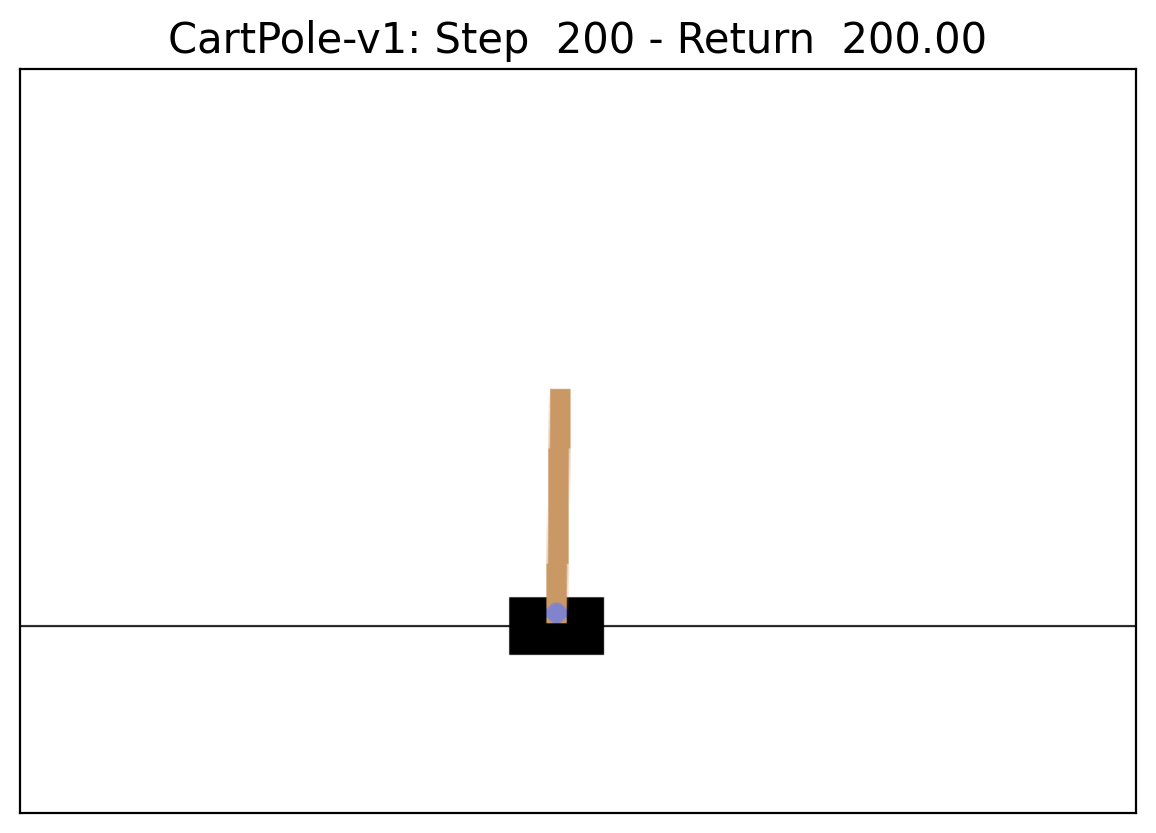

In [48]:
vis = Visualizer(env, env_params, state_seq, cum_rewards)
vis.animate(osp.join("results","CartPole-v1.gif"))

# Debugging

In [ ]:
"""Run training with ES or PPO. Store logs and agent ckpt."""
ppo_yaml = osp.join("expert_agents","CartPole-v1","ppo.yaml")
seed_id = 123
lrate = 5e-04

config = load_config(ppo_yaml, seed_id, lrate)

rng = jax.random.PRNGKey(config.train_config.seed_id)
# Setup the model architecture
rng, rng_init = jax.random.split(rng)
model, policy_params = get_model_ready(rng_init, config.train_config)

In [ ]:
def batch_step(action, state):
    return jax.vmap(cartpole_step, in_axes=(0,0))(
        action, state)
    

In [ ]:
state = jnp.array([0.1,0.1,0.1,0.1])
action = jnp.array([-1.])

In [ ]:
state = cartpole_step(action,state)
state

In [ ]:
state_batch = [jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,))]
state_batch = jnp.stack(state_batch,axis=1)
action_batch = jnp.array(np.random.randint(0,2,5)).astype(float).reshape(-1,1)

In [ ]:
next_state  = batch_step(
   action_batch,state_batch
)
next_state

In [ ]:
state_batch = [jnp.ones(5),
                       jnp.ones(5),
                       jnp.ones(5),
                       jnp.ones(5)]
state_batch = jnp.stack(state_batch,axis=1)
action_batch = jnp.ones(5).reshape(-1,1)*-5

In [ ]:
next_state  = batch_step(
   action_batch,state_batch
)

In [ ]:
next_state

In [ ]:
# Jit-Compiled Episode Rollout
from functools import partial

jit_rollout = jax.jit(partial(kinematics,step_fn=cartpole_step))

In [ ]:
state = jnp.ones(4)*0.1
action = jnp.array(np.random.randint(0,2,10)).reshape(-1,1)
action.ravel()

In [ ]:
x_rollout = jit_rollout(action,state)

In [ ]:
x_rollout

In [ ]:
state_t =  jnp.array([0.25,.1,0.2,0.3])
action = jnp.array([15])
for t in range(10):
  state_t = cartpole_step(action,state_t)
  print(state_t)

In [ ]:
state = jnp.array([0.25,.1,0.2,0.3])
action = jnp.ones(10).reshape(-1,1)*15
x_rollout = jit_rollout(action,state)
x_rollout

In [ ]:
cartpole_dynamics = jax.vmap(jit_rollout,in_axes=(0,None))

action = jnp.ones((10,5,1))*15

cartpole_dynamics(action,state)